In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import soundfile as sf
import jpeglib

from PIL import Image
from scipy.fft import fft, ifft, fftshift, dct

#### Load files and init

In [2]:
img_path = "../bird.jpg"
output_path = "./bird_out.jpg"
audio_path = "../TongNian.m4a"

img = Image.open(img_path)

fs = 44100
audio, _ = librosa.load(audio_path, sr=fs)
# audio = np.pad(audio, (0, 4032*3024 - len(audio)))
n = len(audio)

filter_num = 1524096
newfs = fs*2*filter_num//n

/var/folders/kw/s9c95h691ds9ltpqkjx0s0_40000gn/T/ipykernel_76920/878003622.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(audio_path, sr=fs)
/Users/bingxisong/python/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [3]:
sd.play(audio, fs)

#### Functions:

In [4]:
def get_half_fft(audio, filter_num):
    audio_fft = fft(audio)
    n = len(audio)
    res = fftshift(audio_fft)[n//2-filter_num: n//2]
    return res, filter_num

def get_audio(half_fft):
    n = 2*len(half_fft)
    neg_fft = np.conj(half_fft[::-1])
    full_fft = np.zeros(n, dtype=complex)
    full_fft[:n//2] = half_fft
    full_fft[n//2:] = neg_fft
    
    audio = np.real(ifft(fftshift(full_fft)))
    return audio

def save(ycbcr):
    img_jpeg = jpeglib.read_dct(img_path)
    
    jpeg = jpeglib.from_spatial(ycbcr, jpeglib.Colorspace.JCS_YCbCr)
    jpeg.qt = img_jpeg.qt
    jpeg.write_spatial(output_path)

def encode_ch(ch, arr):
    arr_flat = arr.reshape(-1, 1)
    bin_shifted = np.right_shift(arr_flat, [14, 12, 10, 8, 6, 4, 2, 0])
    bin_masked = bin_shifted & 0b11
    bin_arr = bin_masked.astype('uint8').reshape(ch.shape)
    ch_res = ((ch & 0b11111100) | bin_arr).astype('uint8')
    return ch_res

def encode(img):
    img_ycbcr = img.convert('YCbCr')
    y, cb, cr= img_ycbcr.split()
    y, cb, cr = np.array(y), np.array(cb), np.array(cr)
    
    half_fft, _ = get_half_fft(audio, filter_num)
    half_fft = np.round(half_fft)
    
    real, imag = half_fft.real.astype('int16'), half_fft.imag.astype('int16')
    
    cb_res = encode_ch(cb, real)
    cr_res = encode_ch(cr, imag)

    ycbcr_arr = np.dstack((y, cb_res, cr_res))
    save(ycbcr_arr)
    res = Image.fromarray(ycbcr_arr, mode='YCbCr')
    
    return res, half_fft

def decode_ch(ch):
    bin_remasked = (ch & 0b11).reshape(-1, 8)
    bin_reshifted = np.left_shift(bin_remasked, [14, 12, 10, 8, 6, 4, 2, 0])
    bin_summed = np.bitwise_or.reduce(bin_reshifted, axis=1)
    res = bin_summed.astype('int16').astype('float64').reshape(-1)
    return res

def decode(img):
    y, cb, cr = img.split()
    y, cb, cr = np.array(y), np.array(cb), np.array(cr)
    
    real = decode_ch(cb)
    imag = decode_ch(cr)
    half_fft = (real + 1j * imag).astype('complex64')

    audio = get_audio(half_fft)
    
    return audio, half_fft

#### Encoding and Decoding

In [5]:
res, or_fft = encode(img)
res2 = Image.open(output_path)
audio_res, new_fft = decode(res)

#### Verification

Text(0.5, 1.0, 'Result FFT')

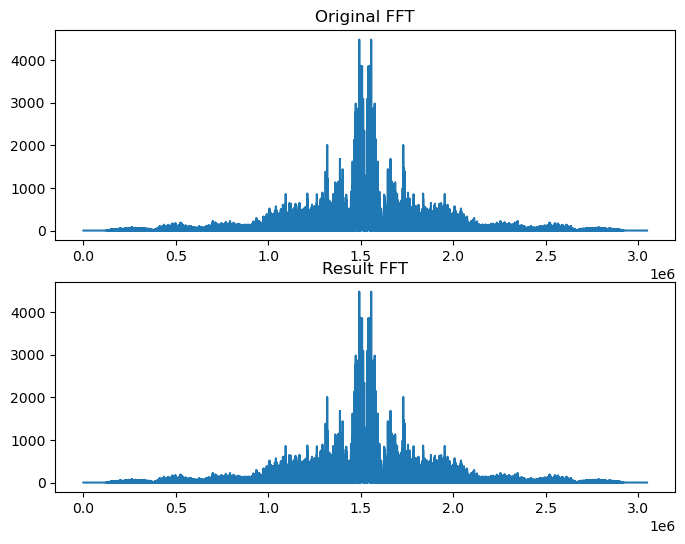

In [6]:
def get_full_fft(half_fft):
    n = 2*len(half_fft)
    neg_fft = np.conj(half_fft[::-1])
    full_fft = np.zeros(n, dtype=complex)
    full_fft[:n//2] = half_fft
    full_fft[n//2:] = neg_fft
    
    return full_fft
    
fig, ax = plt.subplots(2, figsize=(8, 6))
ax[0].plot(np.abs(get_full_fft(or_fft)))
ax[0].set_title("Original FFT")
ax[1].plot(np.abs(get_full_fft(new_fft)))
ax[1].set_title("Result FFT")

#### Results:

In [7]:
a = len(audio_res) / (4032*3024)
print(f"Alpha value: {a}")

Alpha value: 0.25


Text(0.5, 1.0, 'Result')

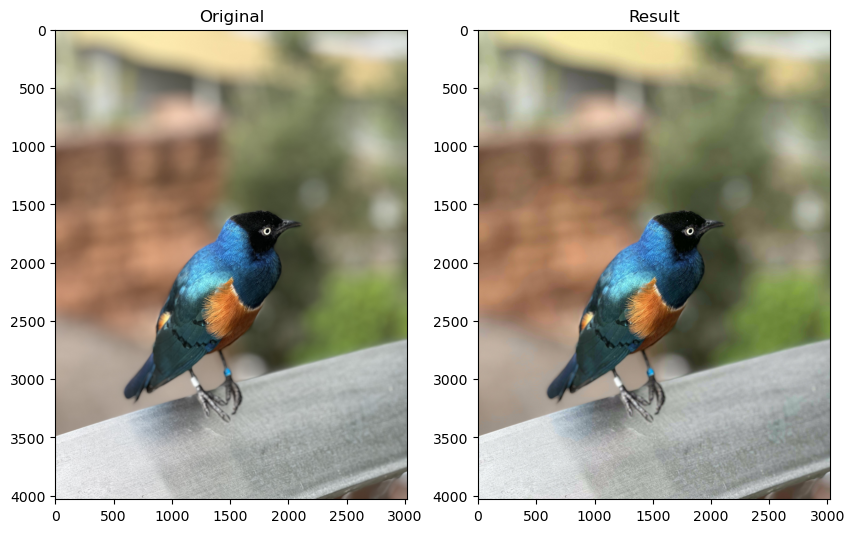

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(img)
ax[0].set_title("Original")
ax[1].imshow(res2)
ax[1].set_title("Result")

In [9]:
sd.play(audio_res, newfs)

In [10]:
sd.stop()